# Use case with the EEGMMI Dataset

<div class="alert alert-warning">
<b>WARNING</b> 
    
This notebook includes multiple trainings that can extend its total run time. We strongly suggest to run it with a device with CUDA installed.

</div>

**Notebook Structure:**


* [Introduction](#Introduction)
* [Self-Supervised Learning Pipeline](#Self-Supervised-Learning-Pipeline)
* [Dataset description and problem design](#Dataset-Description-and-problem-design)
* [Notebook start](#Package-Import)
  * [Data Preparation](#Data-Preparation)
  * [Pretraining Phase](#Pretraining-Phase)
    * [Define Dataloaders](#Define-Pretraining-dataloaders)
    * [Define Augmenter](#Define-the-data-augmenter)
    * [Define Pretraining Model](#Define-pretraining-model-and-other-training-objects)
    * [Run Pretraining](#Pretrain-the-model)
  * [Fine-Tuning Phase](#Fine-tuning-Phase)
    * [Define Dataloaders](#Define-fine-tuning-dataloaders)
    * [Model Transfer](#Define-fine-tuning-model-and-other-training-objects)
    * [Run Fine-Tuning](#Fine-tuning)
    * [Model Evaluation](#Evaluate-fine-tuned-model)
  * [Comparison with Full Supervised Strategy](#Comparison-with-full-supervised)

## Introduction

This notebook will provide an additional example on how to use the selfeeg library on a real-world dataset. 
To do that, we will use the EEGMMI Dataset, which can be downloaded [**here**](https://physionet.org/content/eegmmidb/1.0.0/). However, to facilitate things, we will work with an already preprocessed version of such dataset made available as a resource for the book

```
Deep Learning for EEG-based Brain-Computer Interface: Representations, 
Algorithms and Applications, by Dr. Xiang Zhang and Prof. Lina Yao
```

Preprocessed data can be downloaded [**here**](https://github.com/neergaard/eegbci-data/tree/master)

<div class="alert alert-info">
<b>INFO</b> 
    
Self-Supervised Learning is usually beneficial when there is a small amount of supervision but several datasets to aggregate. In this case, we will work with a single dataset to keep things simple.

</div>

## Self-Supervised Learning Pipeline

The notebook [**Build a self-supervised learning pipeline**](https://selfeeg.readthedocs.io/en/latest/SSL_guide.html) already provides a description on how to build a Self-Supervised Learning Pipeline with selfEEG. To summarize, typical steps include:

1. PRETRAINING:
    1. define the pretraining dataloaders
    2. define the data augmenter
    3. define the pretraining model and optional training elements
    4. pretrain the model
2. FINE-TUNING
    1. define the fine-tuning dataloaders
    2. define the fine-tuning model and optional training elements
    3. transfer the pretrained encoder
    4. fine-tune the model
3. FINAL EVALUATION

In addition, you can consult the following [**Review Paper**](https://ieeexplore.ieee.org/abstract/document/10365170), which provides additional references and datasets used to build EEG-Based Self-Supervised Learning Pipelines as well as a clear description on critical aspects to consider when designing SSL applications on biomedical signals.


## Dataset Description and problem design

**Dataset Description**


As described in the official documentation, the EEGMMI dataset consists of over 1500 one- and two-minute EEG recordings, obtained from 109 volunteers. Subjects performed different motor/imagery tasks while **64-channel EEG** were recorded using the **BCI2000 system**, with a sampling rate of **160 Hz**. In particolar, the following tasks were performed, giving a total of **14 records** per subjects:

1. Baseline, eyes open
2. Baseline, eyes closed
3. Task 1 (open and close left or right fist)
4. Task 2 (imagine opening and closing left or right fist)
5. Task 3 (open and close both fists or both feet)
6. Task 4 (imagine opening and closing both fists or both feet)
7. Task 1
8. Task 2
9. Task 3
10. Task 4
11. Task 1
12. Task 2
13. Task 3
14. Task 4

**Designed Task**

The investigated problem is a binary task based on *Task 2 (imagine opening and closing left or right fist)*. Task 2 data will be used for the *fine-tuning phase*, while data from *other tasks* will be used for the *pretraining phase*. Training, validation, and test sets will be created via subject-based splits.

## Package Import

First, let's import all the packages necessary to run this notebook.

<div class="alert alert-warning">
<b>WARNING</b> 
    
to run this notebook you will also need <b>matplotlib</b> and <b>scikit-learn</b>, which are not dependecies of the selfeeg library. Be sure to install them in your environment.

</div>

In [1]:
# IMPORT BASE PACKAGES
import os
import random
import pickle
import copy
import sys
sys.path.append('..')  # needed if you run this inside the selfeeg/doc folder

import selfeeg
import selfeeg.augmentation as aug
import selfeeg.dataloading as dl

# IMPORT CLASSICAL PACKAGES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Draw figures inline with this notebook
%matplotlib inline

# IMPORT TORCH
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

# set seeds for reproducibility
seed = 1234
random.seed( seed )
np.random.seed( seed )
torch.manual_seed( seed )
plt.style.use('seaborn-v0_8-white')
plt.rcParams['figure.figsize'] = (15.0, 6.0)

## Data Preparation

To run this notebook, it is necessary to download the preprocessed dataset from the following [**GitHub repository**](https://github.com/neergaard/eegbci-data/tree/master). In short, it necessary to:

1. clone the repository with ``git clone https://github.com/xiangzhang1015/Deep-Learning-for-BCI.git`` (or download its zip version)
2. Unzip all the files in the repository's ``dataset`` folder
3. Put all the unzipped files in a folder with the name ``Data``, placed in the current working directory, or, alternatively, just set the path below accordingly

Steps are simple but, just in case, here is a set of commands to include in a cell to automatically download and unzip the data in a Data folder

    !mkdir Data
    !wget https://github.com/xiangzhang1015/Deep-Learning-for-BCI/archive/refs/heads/master.zip
    !unzip master.zip "Deep-Learning-for-BCI-master/dataset/*"
    !mv -v Deep-Learning-for-BCI-master/dataset/* Data
    !rm master.zip

Downloaded data are 109 2-dimensional numpy arrays where each file collects all the records of the same subject, already well-preprocessed. 

Since we are working with a single dataset that can be totally preloaded, there's no need to use the **dataloading** module, which is designed for a collection of datasets impossible to directly load on your device. Therefore, we will just preload all the samples and create a basic Dataset class to fed to the Dataloader.

In [2]:
# ----------- Set Dataset path -------------
# If not this, change it with the right path
dataPath = 'Data/'

In [3]:
def get_MMI_subject_data(
    path: str,
    subject: int, 
    pretrain_label: list[int]=[0,1,2,3,6,7,8,9], 
    finetune_label: list[int]=[4,5],
    window: float=4.1,
    overlap: float=0., 
):
    """
    ``get_MMI_subject_data`` will load and separate subject-specific 
    data from the Physionet EEG Motor Movement/Imagery (EEGMMI) Dataset
    for Self-Supervised Learning (SSL) applications. Loaded data are those 
    already well-preprocessed and provided as a resource for the book: 
    
        Deep Learning for EEG-based Brain-Computer Interface: Representations, 
        Algorithms and Applications, by Dr. Xiang Zhang and Prof. Lina Yao 

    Data, tutorials, and more info about the provided format can be found 
    in the official git repository available at:
        
        https://github.com/xiangzhang1015/Deep-Learning-for-BCI
    
    Parameters
    ----------
    path: str
        Path to the data root folder. It will be concatenated with the subj's file name.
    subject: int
        An integer defining the subject ID. Must be in [1, 109].
    pretrain_label: list[int]
        A list of label to put in the pretraining dataset. Must be in [0,10].
        Values are associated with the following labels are: 0: open eyes,
        1: close eyes, 2: left hand, 3: right hand, 4: image left hand,
        5: image right hand, 6: open fists, 7: open feet, 8: image fist,
        9: image feet, 10: rest. Default = [0,1,2,3,6,7,8,9]
    finetune_label: list[int]
        Same as pretrain_label but for the fine-tuning dataset. Default = [4,5]
    window: float
        The length of the window to consider. Must be a float lower than 4.1.
        Default = 4.1
    overlap: float
        The overlap between consecutive windows of the same trial. Must be in 
        [0,1). Default = 0

    Returns
    -------
    pretrain_data: numpy array
        Numpy array of shape [sample, channel, time] with all the subject's
        samples to use for the pretraining
    pretrain_lab: numpy array
        Numpy array with the pretrain_data samples label
    finetune_data: numpy array
        Numpy array of shape [sample, channel, time] with all the subject's
        samples to use for the fine-tuning
    finetune_lab: numpy array
        Numpy array with the finetune_data samples label
    
    """
    # Just some checks to make this function more robust
    if int(subject)<1 or int(subject)>109:
        raise ValueError('wrong subject ID')
    if not(isinstance(path,str)):
        raise ValueError('path must be a string')
    elif path[-1] != os.sep:
        path = path + os.sep
    if len(set(pretrain_label).intersection(set(finetune_label)))>0:
        raise ValueError('pretraining and finetuning labels must be different')
    if window<0 or window>4.1:
        raise ValueError('window must be in [0,4.1]') 
    
    # load data
    data = np.load(f'{dataPath}{int(subject)}.npy')
    # get time points where the label change to speed up extraction
    label_change = np.ediff1d(data[:,64]).nonzero()[0]
    pretrain_data = []
    pretrain_lab = []
    finetune_data = []
    finetune_lab = []
    Nwindow = int(160*window) # Sampling rate is 160
    Noverlap = int(Nwindow*overlap) # Round everything
    idx = 0

    # basically this block will scroll the loaded array from start to end
    # jumping by (Nwindow-Noverlap) sample at a time. Conditions are:
    # 1. The idx has a label to exclude, jump to the next segment
    # 2. The idx has a label to include but there are not enough time samples
    #    to fill the entire window. Jump to the next segment.
    # 3. The ids has a label to include and there are enough samples to fill
    #    the entire window. Add sample and jump by (Nwindow-Noverlap) steps.
    while ( (idx+Nwindow) < data.shape[0]):
        if data[idx,64] in pretrain_label:
            if  data[idx+Nwindow-1,64] == data[idx,64]:
                pretrain_data.append(data[idx:idx+Nwindow,:64])
                pretrain_lab.append(data[idx,64])
                idx = idx+Nwindow-Noverlap
            else:
                idx = label_change[np.searchsorted(label_change,[idx],side='right')[0]]+1
        elif data[idx,64] in finetune_label:
            if  data[idx+Nwindow-1,64] == data[idx,64]:
                finetune_data.append(data[idx:idx+Nwindow,:64])
                finetune_lab.append(data[idx,64])
                idx = idx+Nwindow-Noverlap
            else:
                idx = label_change[np.searchsorted(label_change,[idx],side='right')[0]]+1
        else:
            idx = label_change[np.searchsorted(label_change,[idx],side='right')[0]]+1

    pretrain_data = np.stack(pretrain_data, 0).astype('float32')
    pretrain_data = np.transpose(pretrain_data, (0,2,1))
    pretrain_lab  = np.array(pretrain_lab).astype('float32')
    
    finetune_data = np.stack(finetune_data, 0).astype('float32')
    finetune_data = np.transpose(finetune_data, (0,2,1))
    finetune_lab  = np.array(finetune_lab).astype('float32')
    
    return pretrain_data, pretrain_lab, finetune_data, finetune_lab


def gather_subjects_data(
    path: str, 
    subject_ids: list, 
    pretrain_label: list[int]=[0,1,2,3,6,7,8,9], 
    finetune_label: list[int]=[4,5],
    window: float=4.1,
    overlap: float=0.0
):
    """
    ``gather_subjects_data`` calls the ``get_MMI_subject_data``
    for each subject listed in subject_ids, then concatenate all the arrays.
    """
    N = len(subject_ids)
    Xpre  = [None]*N 
    Ypre  = [None]*N  
    Xfine = [None]*N 
    Yfine = [None]*N 
    for n, i in enumerate(subject_ids):
        Xpre[n], Ypre[n], Xfine[n], Yfine[n] = get_MMI_subject_data(
            dataPath, 
            subject = i,
            pretrain_label = pretrain_label,
            finetune_label = finetune_label,
            window = window,
            overlap = overlap
        )
    Xpre  = torch.from_numpy( np.concatenate(Xpre,0))
    Ypre  = torch.from_numpy( np.concatenate(Ypre,0))
    Xfine = torch.from_numpy( np.concatenate(Xfine,0))
    Yfine = torch.from_numpy( np.concatenate(Yfine,0))
    return Xpre, Ypre, Xfine, Yfine
    

In [4]:
# random select subjects to put in train, val, and test
all_id = [i for i in range(1, 110)]
random.shuffle(all_id)
train_id = all_id[0:70]
val_id = all_id[70:70+17]
test_id = all_id[70+17:]

# create train tensors
Xpre_train, Ypre_train, Xfine_train, Yfine_train = gather_subjects_data(
    path = dataPath, subject_ids = train_id
)
# create validation tensors
Xpre_val, Ypre_val, Xfine_val, Yfine_val = gather_subjects_data(
    path = dataPath, subject_ids = val_id
)

# There's no need to have a test set during pretraining
_, _, Xfine_test, Yfine_test = gather_subjects_data(
    path = dataPath, subject_ids = test_id
)

# directly rescale and encode fine_tuning data
Xfine_train = selfeeg.utils.scale_range_soft_clip(Xfine_train, 80, 3.5, 'uV', True)
Yfine_train = (Yfine_train > 4).to(dtype=torch.float32)
Xfine_val = selfeeg.utils.scale_range_soft_clip(Xfine_val, 80, 3.5, 'uV', True)
Yfine_val = (Yfine_val > 4).to(dtype=torch.float32)
Xfine_test = selfeeg.utils.scale_range_soft_clip(Xfine_test, 80, 3.5, 'uV', True)
Yfine_test = (Yfine_test > 4).to(dtype=torch.float32)

## Pretraining Phase

### Define Pretraining dataloaders

Since we have directly preloaded the entire dataset, there is no need to use the custom classes and function of the selfEEG's dataloading module.

In [5]:
# define some parameters
Chan = 64
freq = 160
window = 4.1
batchsize = 64
nb_classes=2
Samples = int(freq*window)

In [6]:
class EEGMMIDataset(Dataset):
    def __init__(self, X, Y=None):
        super().__init__()
        self.X = X
        self.Y = Y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self,index):
        if self.Y is None:
            return self.X[index]
        else:
            return self.X[index], self.Y[index]

In [7]:
# define training dataloader
trainset = EEGMMIDataset(Xpre_train)
trainloader = DataLoader(dataset = trainset, batch_size = batchsize)

# define validation dataloader
valset = EEGMMIDataset(Xpre_val)
valloader = DataLoader(dataset = valset, batch_size = batchsize, shuffle = False)

### Define the data augmenter

Now we need to define an augmenter. To keep things simple, we define an augmenter which combines:

1. the addition of some noise or channel lost from ``add_band_noise`` or ``masking``.
2. the ``warp`` or ``crop_and_resize`` or ``permute`` augmentation.
3. a final rescale of the range [-80, 80] uV in [-1, 1] with soft clipping with horizontal asintote of 3.5.

This is similar to the augmentation proposed in the augmentation module introductory book

In [8]:
# DEFINE AUGMENTER
# First block: noise addition
AUG_band = aug.DynamicSingleAug(
    aug.add_band_noise, 
    discrete_arg={
        'bandwidth': ["delta", "theta", "alpha", "beta", (30,49) ], 
        'samplerate': freq,
        'noise_range': 1
    }
)
AUG_mask = aug.DynamicSingleAug(
    aug.masking,
    discrete_arg = {'mask_number': [1,2,3,4], 'masked_ratio': 0.25}
)
Block1 = aug.RandomAug(AUG_band, AUG_mask, p = [0.7, 0.3])

# second block: warp or crop and resize
AUG_crop = aug.DynamicSingleAug(
    aug.crop_and_resize,
    discrete_arg = {'batch_equal': True},
    range_arg = {'N_cut': [1, 4], 'segments': [12,15]},
    range_type = {'N_cut': True, 'segments': True}
)

AUG_permute = aug.DynamicSingleAug(
    aug.permutation_signal,
    discrete_arg = {'segments': [15], 'batch_equal': True},
    range_arg = {'seg_to_per': [2, 5]},
    range_type = {'seg_to_per': True}
)
AUG_warp = aug.DynamicSingleAug(
    aug.warp_signal,
    discrete_arg = {'segments': [10], 'batch_equal': True},
    range_arg = {'squeeze_strength': [0.75,0.9], 'stretch_strength': [1.1,1.5]},
    range_type = {'squeeze_strength': False, 'stretch_strength': False}
)
Block2 = aug.RandomAug(AUG_crop, AUG_permute, AUG_warp, p = [0.3,0.3,0.4])

# third block: rescale
Block3 = lambda x: selfeeg.utils.scale_range_soft_clip(x, 80, 3.5, 'uV', True)

# FINAL AUGMENTER: SEQUENCE OF THE THREE RANDOM LISTS
Augmenter = aug.SequentialAug(Block1, Block2, Block3)

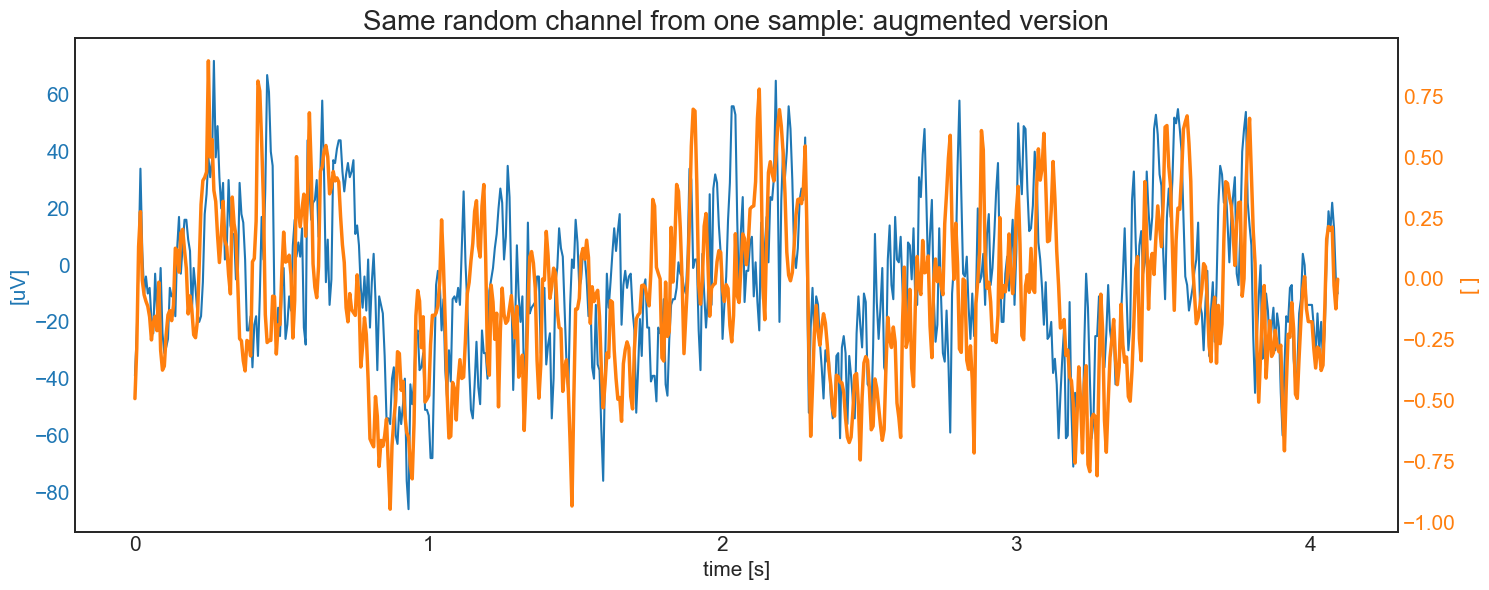

In [9]:
# visualize a random data augmentation
Sample = trainset.__getitem__(random.randint(0,len(trainset)))
t = np.linspace(0, Sample.shape[1]-1, Sample.shape[1])/freq
SampleAug = Augmenter(Sample)
RandChan= random.randint(0,Chan-1)

fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('time [s]', fontsize=15)
ax1.set_ylabel('[uV]', color=color, fontsize=15)
ax1.plot(t,  Sample[RandChan,:], color=color)
ax1.tick_params(axis='y', labelcolor=color, labelsize=15)
ax1.tick_params(axis='x', labelsize=15)
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('[ ]', color=color, fontsize=15) # we've already handled the x-label
ax2.plot(t, SampleAug[RandChan,:],color=color, linewidth=2.5)
ax2.tick_params(axis='y', labelsize=15, labelcolor=color)
plt.title('Same random channel from one sample: augmented version', fontsize=20)
fig.tight_layout()
plt.show()

### Define pretraining model and other training objects

Now we need to define the pretraining model. To do that, we need to:

1. instantiate an nn.Module defining the encoder (backbone)
2. instantiate the right SSL module, giving the encoder and the network head's spec.

For now, let's use a simple EEGNet with default parameters, and SimCLR as the SSL algorithm.

<div class="alert alert-info">
<b>NOTE 1</b> 
    
each model in the <b>models</b> module have an extra class with only the encoder with the name <b>modelnameEncoder</b> (e.g., EEGNetEncoder). This will make model creation much easier. 

</div>

<div class="alert alert-info">
<b>NOTE 2</b> 
    
each model in the <b>ssl</b> module can accept a list or a nn.Module to create the network head. In case of a list, the head will be a sequence of dense layer with input and output size equal to the values of the list. Batchnorm and activation are based on the original works.

</div>

<div class="alert alert-warning">
<b>WARNING</b> 
    
Remember to check if the encoder output size matches the head input size. All modules in the ssl class doesn't check that.

</div>

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Encoder
NNencoder= selfeeg.models.EEGNetEncoder(Chans=Chan)

# SSL model
head_size=[320, 64, 32]
SelfMdl = selfeeg.ssl.SimCLR(
    encoder = NNencoder,
    projection_head = head_size
).to(device=device)

# loss (fit method has a default loss based on the SSL algorithm)
loss=selfeeg.losses.simclr_loss
loss_arg={'temperature': 0.15}

# optimizer
optimizer = torch.optim.Adam(SelfMdl.parameters(), lr=1e-3)

# lr scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.97)

### Pretrain the model

Each SSL algorithm has an already implemented fit method, similar to scikitlearn or Keras. Of course it's not complete as the fit of bigger framewoks, but it certainly save you lots of lines of code and help you monitorate the training. Since this is just a tutorial we will run only 50 epochs of training

In [11]:
loss_info = SelfMdl.fit(
    train_dataloader = trainloader, 
    augmenter = Augmenter, 
    epochs = 50,
    optimizer = optimizer, 
    loss_func = loss, 
    loss_args = loss_arg,
    lr_scheduler = scheduler, 
    validation_dataloader = valloader,
    verbose = False, 
    device = device, 
    return_loss_info = True
)

/home/delpup/miniconda3/envs/selfdlp/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/Convolution.cpp:1003.)
  return F.conv2d(input, weight, bias, self.stride,


## Fine-tuning Phase

Now that the encoder is pretrained, let's perform fine-tuning. To do that, we need to recreate the right dataloaders and models. After that, the **selfeeg** library provides a **fine-tuning** function that is similar to the fit method.

### Define fine-tuning dataloaders

This phase is basically the same as the previous one. The only differences are:

1. We are using the fine-tuning data
2. We are creating a test set for evaluation
3. We need to extract a label from each sample.

The used classes and methods are the same already used from the dataloading module

In [12]:
# define training dataloader
trainsetFT = EEGMMIDataset(Xfine_train, Yfine_train)
trainloaderFT = DataLoader(dataset = trainsetFT, batch_size= batchsize)

# define validation dataloader
valsetFT = EEGMMIDataset(Xfine_val, Yfine_val)
valloaderFT = DataLoader(dataset = valsetFT, batch_size= batchsize, shuffle=False)

# define test dataloader
testsetFT = EEGMMIDataset(Xfine_test, Yfine_test)
testloaderFT = DataLoader(dataset = testsetFT, batch_size= batchsize, shuffle=False)

### Define fine-tuning model and other training objects

Remember that in this phase you need to transfer the pretrained encoder

In [21]:
FinalMdl = selfeeg.models.EEGNet(nb_classes = 2, Chans = Chan, Samples = Samples)

# Transfer the pretrained backbone and 
# move the final model to the chosen device
SelfMdl.train() 
SelfMdl.to(device='cpu') 
FinalMdl.encoder = SelfMdl.get_encoder()
FinalMdl.train()
FinalMdl.to(device=device)

# Define Loss
def loss_fineTuning(yhat, ytrue):
    yhat = torch.squeeze(yhat)
    return F.binary_cross_entropy_with_logits(yhat, ytrue)

# Define EarlyStopper
earlystopFT = selfeeg.ssl.EarlyStopping(
    patience=20, min_delta=1e-03, record_best_weights=True)

### Fine-tuning

Fine-tuning can be easily performed with the ``fine-tuning`` method.

<div class="alert alert-info">
<b>NOTE 1</b> 
    
it is better to first pretrain only the new head, then update all model's weights.

</div>

In [22]:
# Define Optimizer for warm-up
optimizerFT = torch.optim.Adam(FinalMdl.parameters(), lr=0.001)

# Define Optimizer
gamma = 0.995
optimizerFT2 = torch.optim.Adam(FinalMdl.parameters(), lr=0.0009)
schedulerFT2 = torch.optim.lr_scheduler.ExponentialLR(optimizerFT2, gamma=gamma)

In [23]:
# START FINE-TUNING
# First warm up by freezing the backbone
do_warmup=True
if do_warmup:
    FinalMdl.encoder.requires_grad_(False)
    finetuning_loss=selfeeg.ssl.fine_tune(
        model                 = FinalMdl,
        train_dataloader      = trainloaderFT,
        epochs                = 20,
        optimizer             = optimizerFT,
        loss_func             = loss_fineTuning, 
        validation_dataloader = valloaderFT,
        verbose               = False,
        device                = device,
        return_loss_info      = True
    )
if do_warmup:
    FinalMdl.encoder.requires_grad_(True)

finetuning_loss=selfeeg.ssl.fine_tune(
    model         = FinalMdl,
    train_dataloader      = trainloaderFT,
    epochs                = 150,
    optimizer             = optimizerFT2,
    loss_func             = loss_fineTuning, 
    lr_scheduler          = schedulerFT2,
    EarlyStopper          = earlystopFT,
    validation_dataloader = valloaderFT,
    verbose               = False,
    device                = device,
    return_loss_info      = True
)

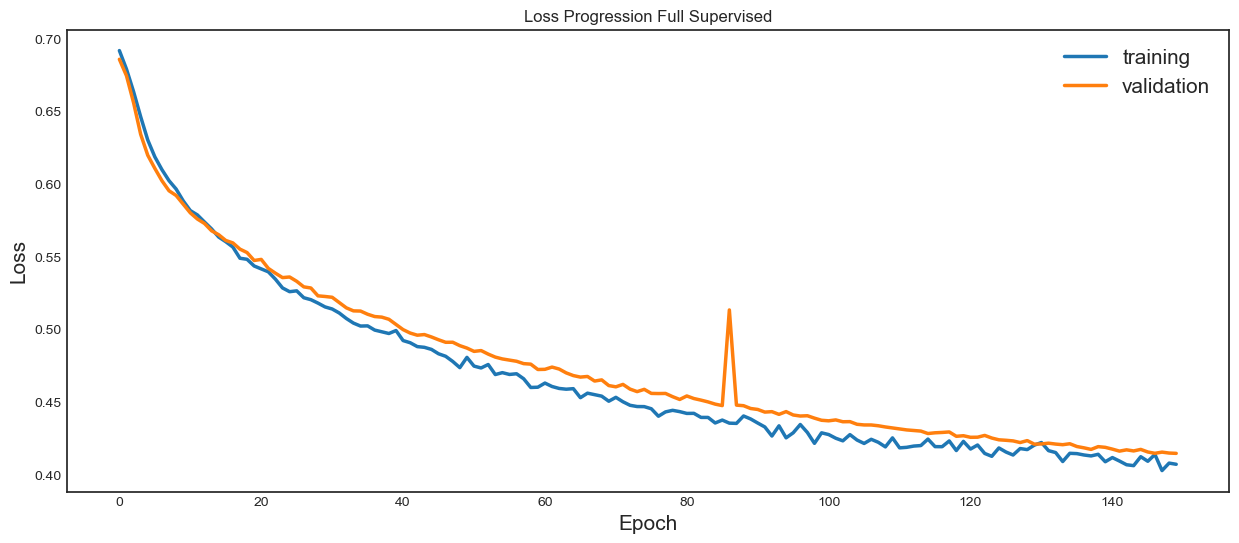

In [24]:
plt.plot([i for i in range(len(finetuning_loss))],
         [finetuning_loss[i][0] for i in range(len(finetuning_loss))],
         linewidth=2.5)
plt.plot([i for i in range(len(finetuning_loss))],
         [finetuning_loss[i][1] for i in range(len(finetuning_loss))],
         linewidth=2.5)
plt.title('Loss Progression Full Supervised')
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend(['training', 'validation'],fontsize=15 )
plt.show()

## Evaluate fine-tuned model

Now you can evaluate your model in whatever method you prefer. Here is a simple example with the classification report from sklearn.

In [25]:
nb_classes=2
FinalMdl.to(device=device)
FinalMdl.eval()
ytrue=torch.zeros(len(testloaderFT.dataset))
ypred=torch.zeros_like(ytrue)
cnt=0
for i, (X, Y) in enumerate(testloaderFT):
    X=X.to(device=device)
    ytrue[cnt:cnt+X.shape[0]]= Y 
    with torch.no_grad():
        yhat = torch.sigmoid(FinalMdl(X)).to(device='cpu')
        ypred[cnt:cnt+X.shape[0]] = torch.squeeze(yhat) 
    cnt += X.shape[0]

print('Results of trivial Example\n')
print(classification_report(ytrue,ypred>0.5))

Results of trivial Example

              precision    recall  f1-score   support

         0.0       0.81      0.83      0.82       486
         1.0       0.83      0.80      0.81       483

    accuracy                           0.82       969
   macro avg       0.82      0.82      0.82       969
weighted avg       0.82      0.82      0.82       969



## Comparison with full supervised

Just for comparison, let's see if there is at least a slightly improvement compared to a standard full supervised pipeline

In [26]:
# Additional Model is EEGNet, which will perform slightly better in this case
FinalMdl2 = selfeeg.models.EEGNet(nb_classes = 2, Chans = Chan, Samples = Samples)

FinalMdl2.to(device=device)

gamma = 0.995
optimizerFT = torch.optim.Adam(FinalMdl2.parameters(), lr=0.0001)
schedulerFT = torch.optim.lr_scheduler.ExponentialLR(optimizerFT, gamma=gamma)

earlystopFT2 = selfeeg.ssl.EarlyStopping(
    patience=10, min_delta=1e-03, record_best_weights=True
)

finetuning_loss = selfeeg.ssl.fine_tune(
    model                 = FinalMdl2,
    train_dataloader      = trainloaderFT,
    epochs                = 150,
    optimizer             = optimizerFT,
    loss_func             = loss_fineTuning, 
    lr_scheduler          = schedulerFT,
    EarlyStopper          = earlystopFT2,
    validation_dataloader = valloaderFT,
    verbose               = False,
    device                = device,
    return_loss_info      = True
)

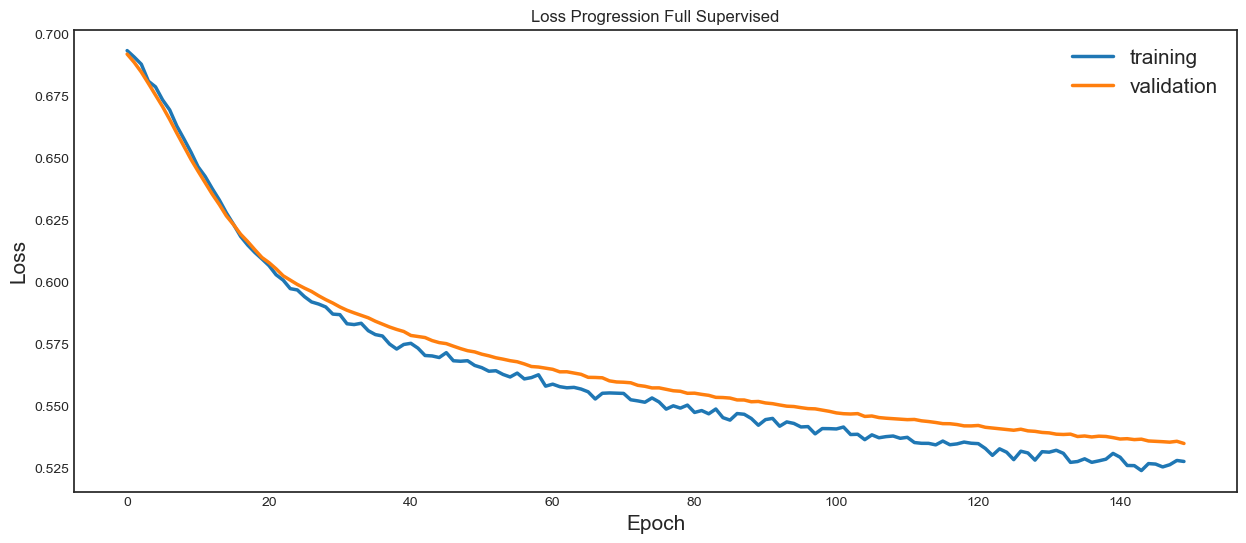

In [27]:
plt.plot([i for i in range(len(finetuning_loss))],
         [finetuning_loss[i][0] for i in range(len(finetuning_loss))],
         linewidth=2.5)
plt.plot([i for i in range(len(finetuning_loss))],
         [finetuning_loss[i][1] for i in range(len(finetuning_loss))],
         linewidth=2.5)
plt.title('Loss Progression Full Supervised')
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend(['training', 'validation'],fontsize=15 )
plt.show()

In [28]:
FinalMdl2.to(device=device)
FinalMdl2.eval()
ytrue=torch.zeros(len(testloaderFT.dataset))
ypred=torch.zeros_like(ytrue)
cnt=0
for i, (X, Y) in enumerate(testloaderFT):
    X=X.to(device=device)
    ytrue[cnt:cnt+X.shape[0]]= Y 
    with torch.no_grad():
        yhat = torch.sigmoid(FinalMdl2(X)).to(device='cpu')
        ypred[cnt:cnt+X.shape[0]] = torch.squeeze(yhat) 
    cnt += X.shape[0]

print('Results of trivial Example\n')
print(classification_report(ytrue,ypred>0.5))

Results of trivial Example

              precision    recall  f1-score   support

         0.0       0.81      0.80      0.80       486
         1.0       0.80      0.81      0.80       483

    accuracy                           0.80       969
   macro avg       0.80      0.80      0.80       969
weighted avg       0.80      0.80      0.80       969



We can see that the pretrained model has achieved a better validation loss in less epochs compared to the full-supervised strategy. Accuracies and F1-scores are almost identical, but this is expected considering that this tutorial uses only a small dataset and EEGNet, which is a very small model.